In [1]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #transform
])

In [4]:
# Define dataset class
class ISIC2017Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, labels_file, transform=None):
        self.data_dir = data_dir
        self.labels_file = labels_file
        self.transform = transform
        self.data = []
        self.classes = []

        self._load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data[idx][0]
        superpixel_name = self.data[idx][1]
        label = self.data[idx][2]

        image_path = os.path.join(self.data_dir, f"{image_name}.jpg")
        superpixel_path = os.path.join(self.data_dir, f"{superpixel_name}.png")

        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Image file not found: {image_path}")
            image = Image.new("RGB", (224, 224))  # Create a blank image if file is missing

        try:
            superpixel = Image.open(superpixel_path).convert("RGB")
        except FileNotFoundError:
            print(f"Superpixel file not found: {superpixel_path}")
            superpixel = Image.new("RGB", (224, 224))  # Create a blank superpixel image if file is missing

        if self.transform:
            image = self.transform(image)
            superpixel = self.transform(superpixel)

        return image, superpixel, label

    def _load_data(self):
        df = pd.read_csv(self.labels_file)

        for idx, row in df.iterrows():
            image_name = row["image_id"]
            superpixel_name = row["image_id"] + "_superpixels"
            melanoma_label = row["melanoma"]
            seborrheic_keratosis_label = row["seborrheic_keratosis"]

            nevus_label = row.get("nevus", 0)

            if melanoma_label == 1:
                label = 0  # Melanoma
            elif seborrheic_keratosis_label == 1:
                label = 2  # Seborrheic Keratosis
            else:
                label = 1  # Nevus

            self.data.append((image_name, superpixel_name, label))

            if label not in self.classes:
                self.classes.append(label)


In [7]:
# Load the dataset paths

train_data_dir = "C:\Work\Cancer Detection\Data\Train"
val_data_dir = "C:\Work\Cancer Detection\Data\Val"
test_data_dir = "C:\Work\Cancer Detection\Data\Test"

train_labels_file = "C:\Work\Cancer Detection\Data\Train.csv"
val_labels_file = "C:\Work\Cancer Detection\Data\Val.csv"
test_labels_file = "C:\Work\Cancer Detection\Data\Test.csv"

num_epochs = 10
batch_size = 64 #64
learning_rate = 0.0001 #0.0001

# Create train and validation datasets
train_dataset = ISIC2017Dataset(train_data_dir, train_labels_file, transform)
val_dataset = ISIC2017Dataset(val_data_dir, val_labels_file, transform)
test_dataset = ISIC2017Dataset(test_data_dir, test_labels_file, transform)


print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

2000
150
600


In [10]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [11]:
#VGG16

# Create model
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, superpixels, labels in train_loader:
        images = images.to(device)
        superpixels = superpixels.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        train_loss += loss.item()

    train_accuracy = 100 * train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, superpixels, labels in val_loader:
            images = images.to(device)
            superpixels = superpixels.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_loss += loss.item()

    val_accuracy = 100 * val_correct / val_total

    # Save the model
    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss / len(train_loader):.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss / len(val_loader):.4f} | Validation Accuracy: {val_accuracy:.2f}%")
    print("=" * 50)

    # Collect metrics for plotting
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

Epoch [1/10]
Train Loss: 0.8286 | Train Accuracy: 68.00%
Validation Loss: 0.8243 | Validation Accuracy: 61.33%
Epoch [2/10]
Train Loss: 0.6525 | Train Accuracy: 72.45%
Validation Loss: 0.7522 | Validation Accuracy: 66.67%
Epoch [3/10]
Train Loss: 0.5337 | Train Accuracy: 79.15%
Validation Loss: 0.6772 | Validation Accuracy: 70.00%
Epoch [4/10]
Train Loss: 0.4282 | Train Accuracy: 83.60%
Validation Loss: 0.6566 | Validation Accuracy: 76.00%
Epoch [5/10]
Train Loss: 0.3118 | Train Accuracy: 88.80%
Validation Loss: 0.7287 | Validation Accuracy: 70.00%
Epoch [6/10]
Train Loss: 0.2018 | Train Accuracy: 94.15%
Validation Loss: 0.6389 | Validation Accuracy: 78.00%
Epoch [7/10]
Train Loss: 0.1305 | Train Accuracy: 97.75%
Validation Loss: 0.6823 | Validation Accuracy: 76.00%
Epoch [8/10]
Train Loss: 0.0822 | Train Accuracy: 99.30%
Validation Loss: 0.7823 | Validation Accuracy: 76.67%
Epoch [9/10]
Train Loss: 0.0508 | Train Accuracy: 99.75%
Validation Loss: 0.8221 | Validation Accuracy: 74.00%
E

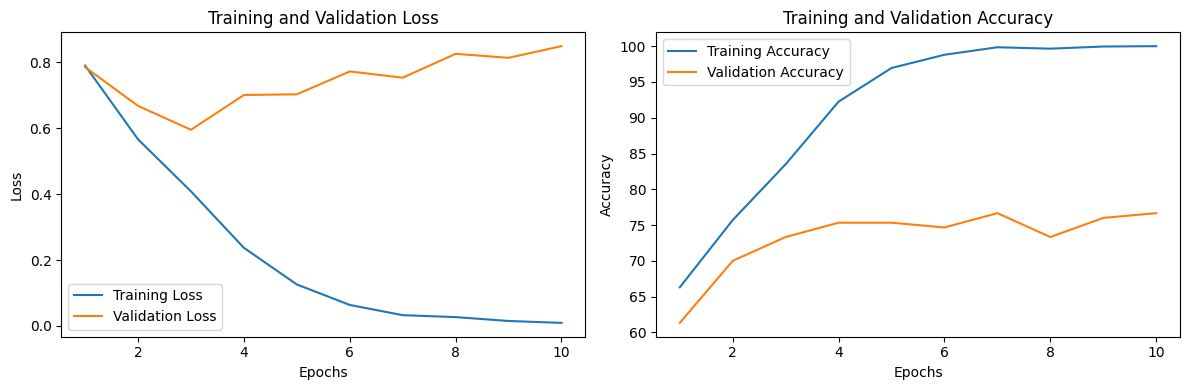

In [16]:
# Plot training and validation metrics
epochs = range(1, num_epochs+1)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Reload the saved model
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(val_dataset.classes))
model.load_state_dict(torch.load(r"C:\Work\Cancer Detection\1stModel\model_epoch_10.pth"))
model = model.to(device)



C:\Users\areez\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\areez\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


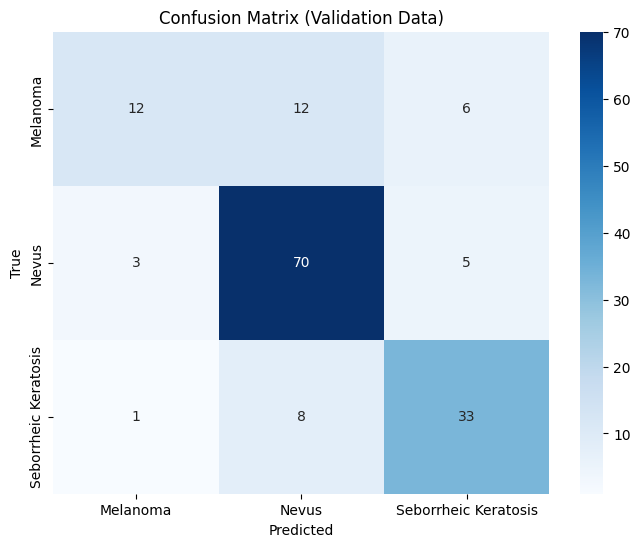

In [14]:
# Evaluate the model on the validation data
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, superpixels, labels in val_loader:
        images = images.to(device)
        superpixels = superpixels.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Save predictions and labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
class_names = ["Melanoma", "Nevus", "Seborrheic Keratosis"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Validation Data)")
plt.show()

In [15]:
plt.savefig(r"C:\Work\Cancer Detection\1stModel\confusion_matrix.png")

<Figure size 640x480 with 0 Axes>

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Compute precision
precision = precision_score(all_labels, all_predictions, average='weighted')

# Compute recall
recall = recall_score(all_labels, all_predictions, average='weighted')

# Compute F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7666666666666667
Precision: 0.7644444444444444
Recall: 0.7666666666666667
F1 Score: 0.7525648803505225


## Test Data

In [6]:
# Set paths and hyperparameters
test_data_dir = "C:\Work\Cancer Detection\Data\Test"
test_labels_file = "C:\Work\Cancer Detection\Data\Test.csv"
test_batch_size = 32

In [7]:
# Create test dataset
test_dataset = ISIC2017Dataset(test_data_dir, test_labels_file, transform)

In [8]:
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

In [9]:
# Reload the saved model
resnet_model = resnet50(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = torch.nn.Linear(num_ftrs, len(test_dataset.classes))
resnet_model.load_state_dict(torch.load(r"C:\Work\Cancer Detection\1stModel\model_epoch_10.pth"))
resnet_model = resnet_model.to(device)

C:\Users\areez\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\areez\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Load the test data and labels
all_images = []
all_labels = []
for images, _, labels in test_loader:
    all_images.extend(images)
    all_labels.extend(labels)

all_images = torch.stack(all_images).to(device)
all_labels = torch.tensor(all_labels).to(device)

In [11]:
# Obtain ResNet-50 predictions and probabilities
resnet_model.eval()
with torch.no_grad():
    resnet_outputs = resnet_model(all_images)
    _, resnet_predictions = torch.max(resnet_outputs, 1)
    resnet_softmax = torch.nn.Softmax(dim=1)
    resnet_probabilities = resnet_softmax(resnet_outputs)
    resnet_predictions = resnet_predictions.cpu().numpy()
    resnet_probabilities = resnet_probabilities.cpu().numpy()

In [12]:
# Reshape ResNet-50 probabilities for scikit-learn compatibility
resnet_probabilities = np.reshape(resnet_probabilities, (-1, len(test_dataset.classes)))

In [13]:
# Flatten ResNet-50 predictions and labels
resnet_predictions_flat = np.ravel(resnet_predictions)
all_labels_flat = np.ravel(all_labels.cpu().numpy())

In [14]:
# Define and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(resnet_probabilities, all_labels_flat)

RandomForestClassifier(random_state=42)

In [15]:
# Define and train the SVM classifier
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier.fit(resnet_probabilities, all_labels_flat)

SVC(probability=True, random_state=42)

In [16]:
# Evaluate the Random Forest model
rf_predictions = rf_classifier.predict(resnet_probabilities)
rf_probabilities = rf_classifier.predict_proba(resnet_probabilities)
rf_accuracy = accuracy_score(all_labels_flat, rf_predictions)
rf_precision = precision_score(all_labels_flat, rf_predictions, average='weighted')
rf_recall = recall_score(all_labels_flat, rf_predictions, average='weighted')
rf_f1 = f1_score(all_labels_flat, rf_predictions, average='weighted')
rf_auc_scores = []
for class_idx in range(len(test_dataset.classes)):
    true_labels = (all_labels_flat == class_idx)
    class_probs = rf_probabilities[:, class_idx]
    auc = roc_auc_score(true_labels, class_probs)
    rf_auc_scores.append(auc)
rf_cm = confusion_matrix(all_labels_flat, rf_predictions)

In [17]:
# Evaluate the SVM model
svm_predictions = svm_classifier.predict(resnet_probabilities)
svm_probabilities = svm_classifier.predict_proba(resnet_probabilities)
svm_accuracy = accuracy_score(all_labels_flat, svm_predictions)
svm_precision = precision_score(all_labels_flat, svm_predictions, average='weighted')
svm_recall = recall_score(all_labels_flat, svm_predictions, average='weighted')
svm_f1 = f1_score(all_labels_flat, svm_predictions, average='weighted')
svm_auc_scores = []
for class_idx in range(len(test_dataset.classes)):
    true_labels = (all_labels_flat == class_idx)
    class_probs = svm_probabilities[:, class_idx]
    auc = roc_auc_score(true_labels, class_probs)
    svm_auc_scores.append(auc)
svm_cm = confusion_matrix(all_labels_flat, svm_predictions)


In [18]:
# Print evaluation metrics for each model
print("ResNet-50 Model:")
print("Accuracy:", accuracy_score(all_labels_flat, resnet_predictions))
print("Precision:", precision_score(all_labels_flat, resnet_predictions, average='weighted'))
print("Recall:", recall_score(all_labels_flat, resnet_predictions, average='weighted'))
print("F1 Score:", f1_score(all_labels_flat, resnet_predictions, average='weighted'))
for class_idx, auc in enumerate(rf_auc_scores):
    print(f"AUC Score (Class {class_idx}): {auc}")
print("Confusion Matrix:")
print(rf_cm)
print("\nRandom Forest Model:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)
for class_idx, auc in enumerate(rf_auc_scores):
    print(f"AUC Score (Class {class_idx}): {auc}")
print("Confusion Matrix:")
print(rf_cm)
print("\nSVM Model:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1 Score:", svm_f1)
for class_idx, auc in enumerate(svm_auc_scores):
    print(f"AUC Score (Class {class_idx}): {auc}")
print("Confusion Matrix:")
print(svm_cm)

ResNet-50 Model:
Accuracy: 0.7366666666666667
Precision: 0.7517632436662287
Recall: 0.7366666666666667
F1 Score: 0.7385451357348483
AUC Score (Class 0): 1.0
AUC Score (Class 1): 1.0
AUC Score (Class 2): 1.0
Confusion Matrix:
[[117   0   0]
 [  0 393   0]
 [  0   0  90]]

Random Forest Model:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC Score (Class 0): 1.0
AUC Score (Class 1): 1.0
AUC Score (Class 2): 1.0
Confusion Matrix:
[[117   0   0]
 [  0 393   0]
 [  0   0  90]]

SVM Model:
Accuracy: 0.76
Precision: 0.7497763034067382
Recall: 0.76
F1 Score: 0.7527695061693374
AUC Score (Class 0): 0.7121976252411035
AUC Score (Class 1): 0.8080662806849331
AUC Score (Class 2): 0.8715904139433551
Confusion Matrix:
[[ 55  48  14]
 [ 26 347  20]
 [ 11  25  54]]
